# School distance to houses
This notebook is to calculate the distance between (indepdent) schools and houses. The data used in this example is from the city of New York. The data is available in the `school.py` script.

Written by: **Hanshi Tang**<br>

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pyspark.sql import functions as F  #filtering
import geopandas as gpd
import folium
from folium import GeoJsonTooltip
import openrouteservice
import time
from geopy.distance import geodesic
import numpy as np
import pandas as pd

In [5]:
# import the parquet file
house = pd.read_csv('../data/curated/domain_data.csv')

In [6]:
# import school data
school = pd.read_csv('../data/raw/school.csv')

In [7]:
# percentage of primary schools that are in the government Education Sector
school[school['School_Type'] == 'Primary']['Education_Sector'].value_counts(normalize=True) * 100

Government     67.587209
Catholic       30.087209
Independent     2.325581
Name: Education_Sector, dtype: float64

## Distance to closest school

In [ ]:
def find_closest_school_with_progress(house, school):
    # Convert lat/lon data to NumPy arrays for fast vectorized computation
    house_coords = house[['latitude', 'longitude']].to_numpy()
    school_coords = school[['latitude', 'longitude']].to_numpy()

    # Create arrays to store the closest school distances and indices for each house
    closest_school_distances = []
    closest_school_indices = []

    # Loop over each house and show progress
    total_houses = len(house_coords)
    last_percent_shown = 0  # Track the last percentage shown
    
    for i, house_coord in enumerate(house_coords):
        # Calculate the geodesic distance from this house to all schools
        distances = np.array([geodesic(house_coord, school_coord).kilometers for school_coord in school_coords])
        
        # Find the index of the closest school
        closest_school_index = np.argmin(distances)
        closest_distance = distances[closest_school_index]
        
        # Append the closest school index and distance to the lists
        closest_school_indices.append(closest_school_index)
        closest_school_distances.append(closest_distance)

        # Calculate progress percentage
        progress = (i + 1) / total_houses * 100
        
        # Only print when the progress reaches a new integer percentage
        if int(progress) > last_percent_shown:
            print(f"Progress: {int(progress)}%")
            last_percent_shown = int(progress)

    # Get the corresponding closest school names based on the indices
    closest_school_names = school.iloc[closest_school_indices]['School_No'].values

    # Return a DataFrame with both the closest school name and the distance
    return pd.DataFrame({
        'closest_school': closest_school_names,
        'distance_to_closest_school': closest_school_distances
    })

# Calculate the closest school for each house
closest_schools_df = find_closest_school_with_progress(house, school)

# Add the results to the house DataFrame
house['closest_school'] = closest_schools_df['closest_school']
house['distance_to_closest_school'] = closest_schools_df['distance_to_closest_school']


In [6]:
# Save the DataFrame to a CSV file after processing each batch in data folder
house.to_csv('../data/curated/house_school.csv', index=False)

## Linear distance to closest independent school

In [50]:
# check the number of non-government secondary schools in the data
school['Education_Sector'].value_counts(normalize=True) * 100

Education_Sector
Government     63.339552
Catholic       24.626866
Independent    12.033582
Name: proportion, dtype: float64

In [51]:
def find_closest_independent_school_with_progress(house, school):
    # Filter for Independent secondary schools
    filtered_schools = school[school['Education_Sector'] == 'Independent'].reset_index(drop=True)
    
    # Convert lat/lon data to NumPy arrays for fast vectorized computation
    house_coords = house[['latitude', 'longitude']].to_numpy()
    school_coords = filtered_schools[['latitude', 'longitude']].to_numpy()

    # Create arrays to store the closest school distances and indices for each house
    closest_school_distances = []
    closest_school_indices = []

    # Loop over each house and show progress
    total_houses = len(house_coords)
    last_percent_shown = 0  # Track the last percentage shown
    
    for i, house_coord in enumerate(house_coords):
        # Calculate the geodesic distance from this house to all schools
        distances = np.array([geodesic(house_coord, school_coord).kilometers for school_coord in school_coords])
        
        # Find the index of the closest school
        closest_school_index = np.argmin(distances)
        closest_distance = distances[closest_school_index]
        
        # Append the closest school index and distance to the lists
        closest_school_indices.append(closest_school_index)
        closest_school_distances.append(closest_distance)

        # Calculate progress percentage
        progress = (i + 1) / total_houses * 100
        
        # Only print when the progress reaches a new integer percentage
        if int(progress) > last_percent_shown:
            print(f"Progress: {int(progress)}%")
            last_percent_shown = int(progress)

    # Get the corresponding closest school names based on the indices
    closest_school_names = filtered_schools.iloc[closest_school_indices]['School_No'].values

    # Return a DataFrame with both the closest school name and the distance
    return pd.DataFrame({
        'closest_school': closest_school_names,
        'distance_to_closest_school': closest_school_distances
    })

# Calculate the closest Catholic or Independent secondary school for each house
closest_schools_df = find_closest_independent_school_with_progress(house, school)

# Add the results to the house DataFrame
house['closest_independent_school'] = closest_schools_df['closest_school']
house['distance_to_closest_independent_school'] = closest_schools_df['distance_to_closest_school']


Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
P

In [52]:
# save the DataFrame to a CSV file 
house.to_csv('../data/curated/house_independent_school.csv', index=False)

### Correlation to independent school distance

In [26]:
# import from the curated folder
house = pd.read_csv('../data/curated/house_independent_school.csv')

In [27]:
house["log_distance_to_closest_school"] = np.log1p(house["distance_to_closest_independent_school"])

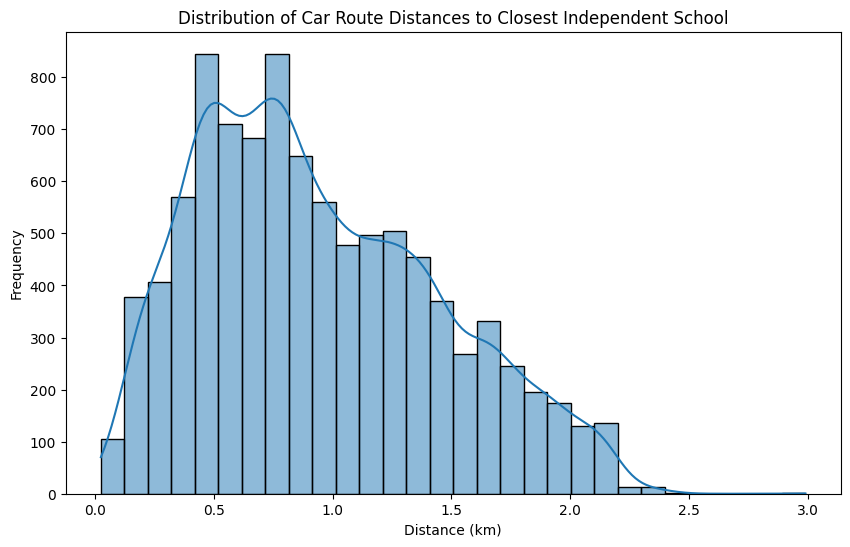

In [18]:
# plot the distribution of the car route distances to the closest primary school
plt.figure(figsize=(10, 6))
sns.histplot(house['log_distance_to_closest_school'], bins=30, kde=True)
plt.title('Distribution of Car Route Distances to Closest Independent School')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()

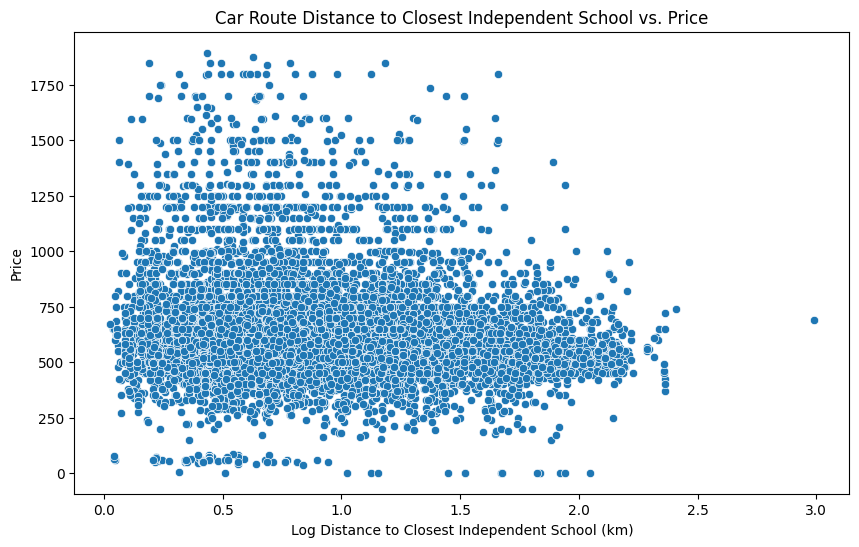

In [57]:
# scatter plot of the car route distances to the closest primary school vs. the price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=house, x='log_distance_to_closest_school', y='extracted_price')
plt.title('Car Route Distance to Closest Independent School vs. Price')
plt.xlabel('Log Distance to Closest Independent School (km)')
plt.ylabel('Price')
plt.show()

In [28]:
# Check correlation between the distance to the closest primary school and the extracted price 
house[['log_distance_to_closest_school', 'extracted_price']].corr()

,log_distance_to_closest_school,extracted_price
log_distance_to_closest_school,1.000000,-0.144937
extracted_price,-0.144937,1.000000


In [29]:
# check correlation to different types of properties for extracted price
house.groupby('property_type')[['log_distance_to_closest_school', 'extracted_price']].corr()

log_distance_to_closest_school  \
property_type                                                                                  
Apartment / Unit / Flat       log_distance_to_closest_school                        1.000000   
                              extracted_price                                      -0.202508   
Carspace                      log_distance_to_closest_school                        1.000000   
                              extracted_price                                      -0.250223   
Duplex                        log_distance_to_closest_school                        1.000000   
                              extracted_price                                       0.777251   
House                         log_distance_to_closest_school                        1.000000   
                              extracted_price                                      -0.285138   
New Apartments / Off the Plan log_distance_to_closest_school                        1.000000   
                              extracted_price                                       0.379532   
New House & Land              log_distance_to_closest_school                        1.000000   
                              extracted_price                                      -0.048649   
Semi-Detached                 log_distance_to_closest_school                        1.000000   
                              extracted_price                                      -0.818138   
Studio                        log_distance_to_closest_school                        1.000000   
                              extracted_price                                      -0.192067   
Terrace                       log_distance_to_closest_school                        1.000000   
                              extracted_price                                       0.255307   
Townhouse                     log_distance_to_closest_school                        1.000000   
                              extracted_price                                      -0.268078   
Villa                         log_distance_to_closest_school                        1.000000   
                              extracted_price                                      -0.386911   

                                                              extracted_price  
property_type                                                                  
Apartment / Unit / Flat       log_distance_to_closest_school        -0.202508  
                              extracted_price                        1.000000  
Carspace                      log_distance_to_closest_school        -0.250223  
                              extracted_price                        1.000000  
Duplex                        log_distance_to_closest_school         0.777251  
                              extracted_price                        1.000000  
House                         log_distance_to_closest_school        -0.285138  
                              extracted_price                        1.000000  
New Apartments / Off the Plan log_distance_to_closest_school         0.379532  
                              extracted_price                        1.000000  
New House & Land              log_distance_to_closest_school        -0.048649  
                              extracted_price                        1.000000  
Semi-Detached                 log_distance_to_closest_school        -0.818138  
                              extracted_price                        1.000000  
Studio                        log_distance_to_closest_school        -0.192067  
                              extracted_price                        1.000000  
Terrace                       log_distance_to_closest_school         0.255307  
                              extracted_price                        1.000000  
Townhouse                     log_distance_to_closest_school        -0.268078  
                              extracted_price                        1.000000

Text(0.5, 1.0, 'Correlation Heatmap for Distance to Closest Independent School and Price')

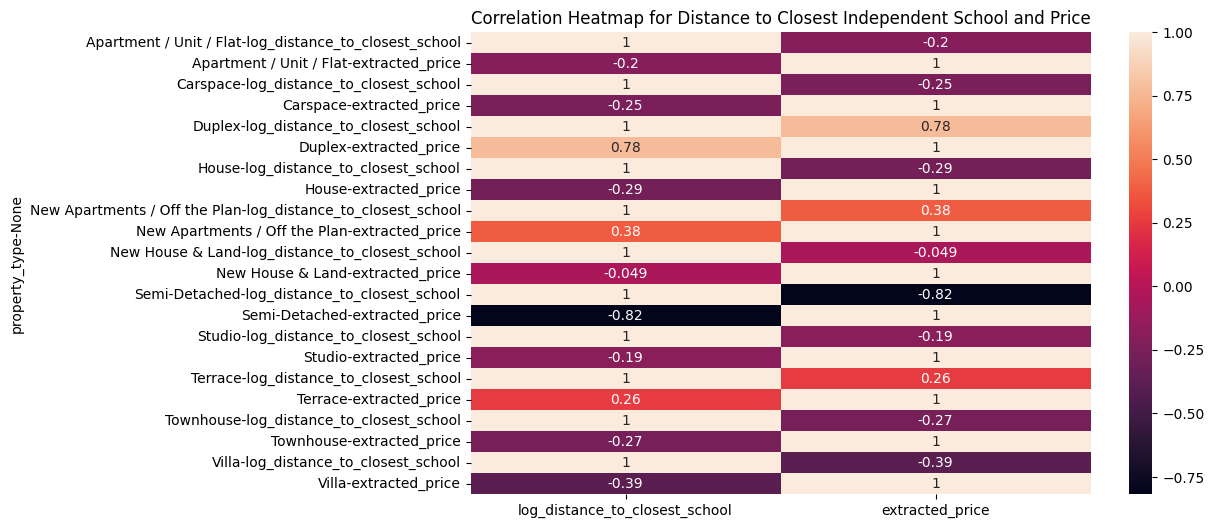

In [30]:
# draw heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(house.groupby('property_type')[['log_distance_to_closest_school', 'extracted_price']].corr(), annot=True)
plt.title('Correlation Heatmap for Distance to Closest Independent School and Price')

### Correlation to school distance

In [20]:
# import from the curated folder
house = pd.read_csv('../data/curated/house_school.csv')

In [21]:
house["log_distance_to_closest_school"] = np.log1p(house["distance_to_closest_school"])

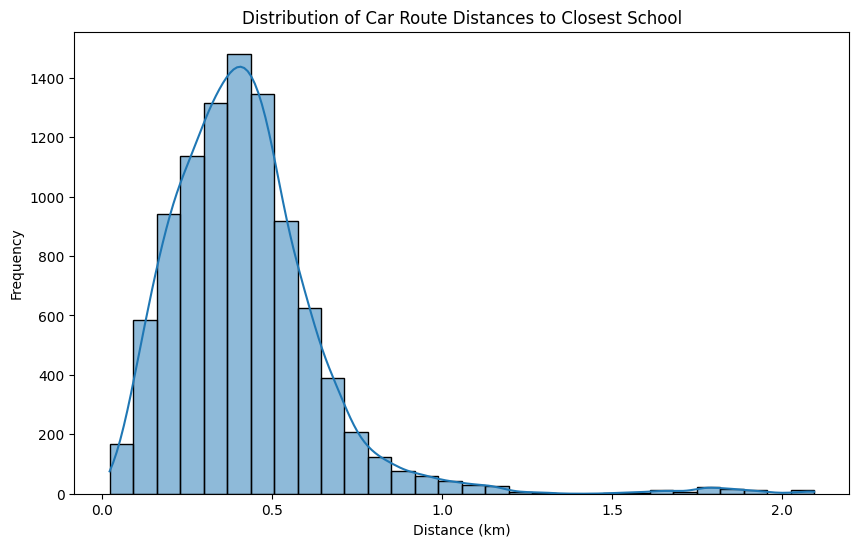

In [22]:
# plot the distribution of the car route distances to the closest primary school
plt.figure(figsize=(10, 6))
sns.histplot(house['log_distance_to_closest_school'], bins=30, kde=True)
plt.title('Distribution of Car Route Distances to Closest School')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()

In [23]:
# Check correlation between the distance to the closest primary school and the extracted price 
house[['log_distance_to_closest_school', 'extracted_price']].corr()

,log_distance_to_closest_school,extracted_price
log_distance_to_closest_school,1.000000,-0.050649
extracted_price,-0.050649,1.000000


In [24]:
# check correlation to different types of properties for extracted price
house.groupby('property_type')[['log_distance_to_closest_school', 'extracted_price']].corr()

log_distance_to_closest_school  \
property_type                                                                                  
Apartment / Unit / Flat       log_distance_to_closest_school                        1.000000   
                              extracted_price                                       0.018298   
Carspace                      log_distance_to_closest_school                        1.000000   
                              extracted_price                                       0.039646   
Duplex                        log_distance_to_closest_school                        1.000000   
                              extracted_price                                       0.554719   
House                         log_distance_to_closest_school                        1.000000   
                              extracted_price                                      -0.153690   
New Apartments / Off the Plan log_distance_to_closest_school                        1.000000   
                              extracted_price                                       0.863500   
New House & Land              log_distance_to_closest_school                        1.000000   
                              extracted_price                                       0.083112   
Semi-Detached                 log_distance_to_closest_school                        1.000000   
                              extracted_price                                       0.255880   
Studio                        log_distance_to_closest_school                        1.000000   
                              extracted_price                                      -0.003332   
Terrace                       log_distance_to_closest_school                        1.000000   
                              extracted_price                                      -0.104903   
Townhouse                     log_distance_to_closest_school                        1.000000   
                              extracted_price                                      -0.084048   
Villa                         log_distance_to_closest_school                        1.000000   
                              extracted_price                                       0.049920   

                                                              extracted_price  
property_type                                                                  
Apartment / Unit / Flat       log_distance_to_closest_school         0.018298  
                              extracted_price                        1.000000  
Carspace                      log_distance_to_closest_school         0.039646  
                              extracted_price                        1.000000  
Duplex                        log_distance_to_closest_school         0.554719  
                              extracted_price                        1.000000  
House                         log_distance_to_closest_school        -0.153690  
                              extracted_price                        1.000000  
New Apartments / Off the Plan log_distance_to_closest_school         0.863500  
                              extracted_price                        1.000000  
New House & Land              log_distance_to_closest_school         0.083112  
                              extracted_price                        1.000000  
Semi-Detached                 log_distance_to_closest_school         0.255880  
                              extracted_price                        1.000000  
Studio                        log_distance_to_closest_school        -0.003332  
                              extracted_price                        1.000000  
Terrace                       log_distance_to_closest_school        -0.104903  
                              extracted_price                        1.000000  
Townhouse                     log_distance_to_closest_school        -0.084048  
                              extracted_price                        1.000000

Text(0.5, 1.0, 'Correlation Heatmap for Distance to Closest School and Price')

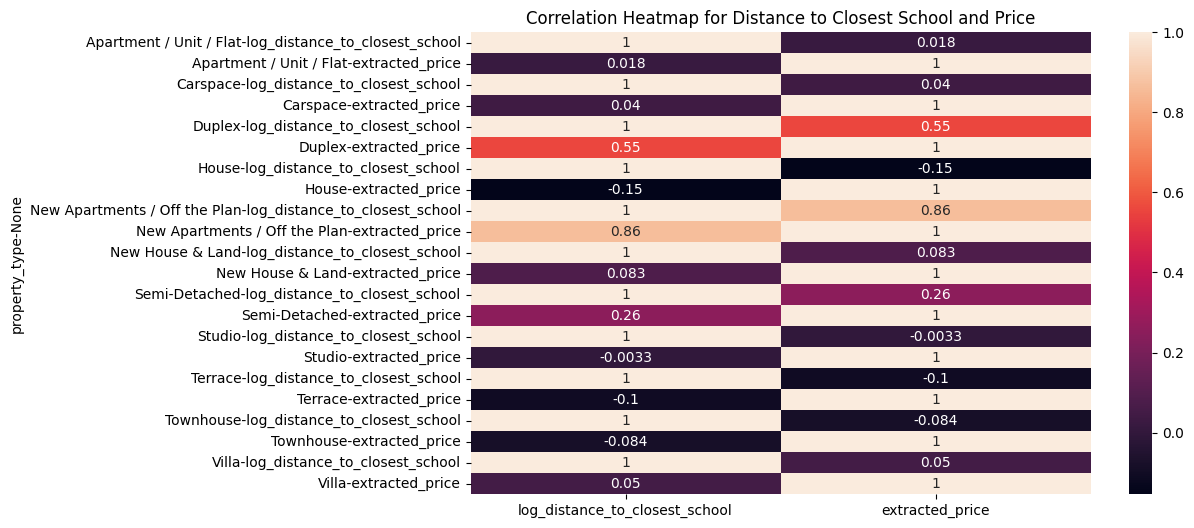

In [25]:
# draw heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(house.groupby('property_type')[['log_distance_to_closest_school', 'extracted_price']].corr(), annot=True)
plt.title('Correlation Heatmap for Distance to Closest School and Price')